Required Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import skimage
import numpy as np
import tensorflow as tf
!pip install pyyaml h5py  # Required to save models in HDF5 format
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Getting the OCTMNIST dataset from PIP

In [2]:
!pip install medmnist
from medmnist import OCTMNIST
dataset_train = OCTMNIST(split="train", download=True)
dataset_test = OCTMNIST(split="test", download=True)
dataset_validate = OCTMNIST(split="val", download = True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=99116bd661329954b8d40f6b06a4f1a38d142208ae4d84749b12f5e295476934
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


100%|██████████| 54938180/54938180 [01:42<00:00, 536407.07it/s]


Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


Shape of the dataset-images

In [3]:
x_train, y_train = dataset_train.imgs, dataset_train.labels
x_test, y_test = dataset_test.imgs, dataset_test.labels
x_val, y_val = dataset_validate.imgs, dataset_validate.labels

print(x_train.shape, y_train.shape, x_train[0].shape)

(97477, 28, 28) (97477, 1) (28, 28)


Resizing the images from 28x28 to 92x92x3

In [4]:
import cv2
import numpy as np

def preprocess_images(images):
    preprocessed_images = []
    for image in images:
        resized_image = cv2.resize(image, (92, 92))
        rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
        preprocessed_images.append(rgb_image)
    return np.array(preprocessed_images)

Shape after performing the pre-processing operation

In [5]:
resized_x_train = preprocess_images(x_train)
resized_x_test = preprocess_images(x_test)
resized_x_val = preprocess_images(x_val)
resized_x_train.shape, resized_x_test.shape, resized_x_val.shape

((97477, 92, 92, 3), (1000, 92, 92, 3), (10832, 92, 92, 3))

Preparing the Base Model - DenseNet121

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(92, 92, 3)
)

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = Flatten()(x)
predictions = Dense(4, activation='softmax')(x)  

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=0.001) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

reduce_learning_rate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

87910968/87910968 [==============================] - 1s 0us/step


Fitting the data

In [7]:
history = model.fit(
    resized_x_train,
    y_train,
    epochs=100,
    validation_data=(resized_x_val, y_val),
    callbacks=[reduce_learning_rate, callbacks]
)

Epoch 1/100
3047/3047 [==============================] - 240s 60ms/step - loss: 0.6219 - accuracy: 0.8001 - val_loss: 0.5943 - val_accuracy: 0.8209 - lr: 0.0010
Epoch 2/100
3047/3047 [==============================] - 180s 59ms/step - loss: 0.5076 - accuracy: 0.8319 - val_loss: 0.6528 - val_accuracy: 0.7783 - lr: 0.0010
Epoch 3/100
3047/3047 [==============================] - 180s 59ms/step - loss: 0.4374 - accuracy: 0.8497 - val_loss: 0.4163 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 4/100
3047/3047 [==============================] - 180s 59ms/step - loss: 0.4224 - accuracy: 0.8590 - val_loss: 0.3921 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 5/100
3047/3047 [==============================] - 180s 59ms/step - loss: 0.4010 - accuracy: 0.8619 - val_loss: 0.3849 - val_accuracy: 0.8725 - lr: 0.0010
Epoch 6/100
3047/3047 [==============================] - 179s 59ms/step - loss: 0.3536 - accuracy: 0.8738 - val_loss: 0.3135 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 7/100
3047/3047 [===========

Loss-Accuracy Graphs

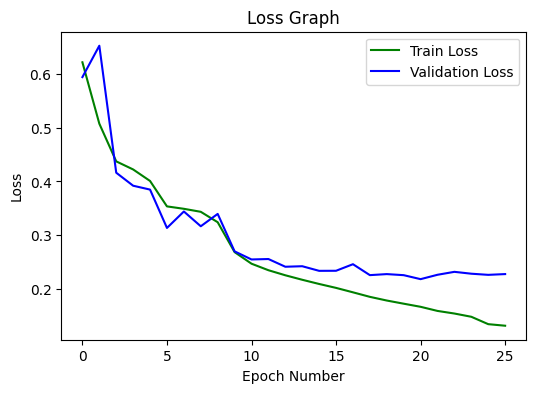

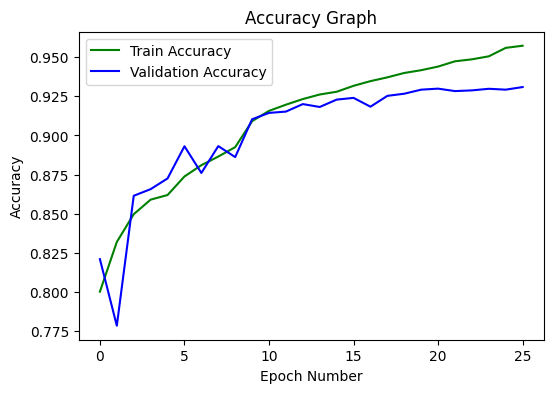

In [8]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch, history.history["loss"], color="green", label="Train Loss")
plt.plot(history.epoch, history.history["val_loss"], color="blue",
label="Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()
plt.subplots(figsize=(6,4))
plt.plot(history.epoch, history.history["accuracy"], color="green",
label="Train Accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], color="blue",
label="Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Graph")
plt.show()

Evaluation results

In [9]:
model.evaluate(resized_x_test, y_test)

32/32 [==============================] - 1s 37ms/step - loss: 0.7394 - accuracy: 0.7710


[0.7393994331359863, 0.7710000276565552]

Saving the trained model

In [10]:
model.save("OCTMNIST__inceptionv3.h5")